In [ ]:
#import pandas as pd

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from sklearn.model_selection import train_test_split
from IPython.display import Image 
import io
#import pydotplus
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

In [ ]:
url = '/content/drive/My Drive/Colab Notebooks/Poverty Prediction/Data/file2.csv'
df = pd.read_csv(url, encoding='utf-8')
df1 = pd.read_csv(url, encoding='utf-8')
df_extra = pd.read_csv(url, encoding='utf-8')

In [ ]:
print("Number of rows in data =",df.shape[0])
print("Number of columns in data =",df.shape[1])
print("\n")
print("**Sample data:**")
df1.head(5)

Number of rows in data = 45812
Number of columns in data = 85


**Sample data:**


,hhid,popwgt,roster_a_5,roster_a_6b,roster_a_7,roster_a_13,educ_a_2,educ_a_3,educ_a_4,educ_a_5,years_educ,health_a1_1,member,nemployed,nmobile,nmobile_per,nemployed_per,tot_difficulties,nread,nread_per,nwrite,nwrite_per,max_edu,tot_edu_yr,avg_edu_yr,spend_on_edu,tot_sci,spend_on_health,hhwgt,housing_a_2,housing_a_3,housing_a_4a,housing_a_4c,housing_a_5b,housing_a_6b,housing_a_7,housing_a_8a,housing_a_8b,housing_a_9,housing_a_10,...,housing_a_17,housing_a_18,housing_a_19,housing_a_21b,housing_a_22,housing_a_25,oincome_a_1b,oincome_a_2,oincome_a_4,oincome_a_6,oincome_a_8,oincome_d_1,agri_a_6,tot_income,tot_agri_val,urbrural_a,zf_a,realpcexp_a,realpce_b,quarter,ruc,division_code,zu16quarters,zl16quarters,zu16,zl16,fexp,hsvalhh,nfexp2,consexp2,hhincome,pcexp,pcincome,pline_nat,rpcexp,rpcincome,lowerpoorquarters,upperpoorquarters,lowerpoor,upperpoor
0,1001,536.84314,1,26.0,1.0,1.0,1.0,1.0,1.0,6.0,6.0,1.0,4,1,2,0.500000,0.250000,24,4,1.00,4,1.00,11.0,23,5.75,19400,2,0,134.21078,4.0,2.0,1.0,3.0,3.0,2.0,640.0,1.0,2.0,2.0,2.0,...,2.0,2.0,2.0,1.0,700000.0,2.0,NaN,NaN,NaN,NaN,40000.0,2.0,0.06,2000,0,2,1544.4044,3597.4141,3606.0095,4,2,10,2792.6943,2019.6479,2756.45,1993.4365,10236.5120,2500.0,7248.833,17485.3440,13500.000,4371.3359,3375.0000,2268.1511,3596.9639,2777.1265,0,0,0,0
1,1003,536.84314,1,23.0,1.0,1.0,1.0,1.0,1.0,10.0,10.0,1.0,4,1,2,0.500000,0.250000,24,4,1.00,4,1.00,10.0,25,6.25,8400,2,0,134.21078,4.0,2.0,1.0,3.0,3.0,2.0,520.0,1.0,2.0,2.0,2.0,...,2.0,2.0,2.0,1.0,1000000.0,2.0,NaN,NaN,NaN,NaN,12000.0,2.0,0.10,1000,0,2,1544.4044,3297.9414,3305.8213,4,2,10,2792.6943,2019.6479,2756.45,1993.4365,10218.9140,2000.0,5810.833,16029.7470,10666.667,4007.4368,2666.6667,2268.1511,3297.5286,2194.2729,0,0,0,0
2,1004,536.84314,1,23.0,1.0,1.0,2.0,2.0,2.0,0.0,0.0,1.0,4,1,3,0.750000,0.250000,24,3,0.75,3,0.75,10.0,7,1.75,16500,2,0,134.21078,2.0,2.0,1.0,3.0,3.0,2.0,200.0,1.0,2.0,2.0,2.0,...,2.0,2.0,2.0,1.0,200000.0,2.0,NaN,NaN,NaN,NaN,15000.0,2.0,0.02,0,1,2,1544.4044,2988.6277,2995.7686,4,2,10,2792.6943,2019.6479,2756.45,1993.4365,7641.3184,2500.0,6885.000,14526.3180,15287.583,3631.5796,3821.8958,2268.1511,2988.2537,3144.8557,0,0,0,0
3,1011,805.26471,1,23.0,2.0,1.0,1.0,1.0,1.0,10.0,10.0,1.0,6,2,4,0.666667,0.333333,36,6,1.00,6,1.00,13.0,60,10.00,13600,3,0,134.21078,5.0,2.0,1.0,3.0,5.0,4.0,640.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,1.0,1200000.0,2.0,1.0,440000.0,NaN,NaN,50000.0,2.0,0.05,1500,1,2,1544.4044,3440.7961,3449.0173,4,2,10,2792.6943,2019.6479,2756.45,1993.4365,13491.3130,3000.0,11594.834,25086.1460,51958.332,4181.0244,8659.7217,2268.1511,3440.3655,7125.6719,0,0,0,0
4,1016,134.21078,1,26.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,1,1,1,1.000000,1.000000,6,1,1.00,1,1.00,3.0,3,3.00,0,1,0,134.21078,2.0,2.0,1.0,3.0,3.0,2.0,280.0,3.0,2.0,2.0,2.0,...,2.0,2.0,2.0,1.0,500000.0,2.0,NaN,NaN,NaN,NaN,NaN,2.0,0.04,0,0,2,1544.4044,5976.2046,5990.4834,4,2,10,2792.6943,2019.6479,2756.45,1993.4365,4504.3823,1500.0,2757.500,7261.8823,8533.333,7261.8823,8533.3330,2268.1511,5975.4565,7021.6729,0,0,0,0


In [ ]:
pip install chart_studio

In [ ]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly import tools
from datetime import date
import plotly.figure_factory as ff

from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import random 
import warnings
import operator

# Missing Values
One of the most important steps of exploratory data analysis is finding missing values in the data and determining how to handle them. Missing values have to be filled in before we use a machine learning model and we need to think of the best strategy for filling them in based on the feature: this is where we'll have to start digging into the data definitions.

First we can look at the percentage of missing values in each column.


In [ ]:
df1 = df1.drop(columns=['hhid', 'popwgt', 'nemployed', 'nmobile', 'tot_difficulties', 'nread', 'nwrite', 'tot_edu_yr',
                 'hhwgt', 'housing_a_10', 'housing_a_11', 'housing_a_12', 'oincome_d_1', 'zu16', 'zl16', 'pline_nat'])


In [ ]:
#shows which column contain missing values
df1.columns[df1.isnull().any()]


Index(['roster_a_6b', 'roster_a_7', 'roster_a_13', 'educ_a_2', 'educ_a_3',
       'educ_a_4', 'educ_a_5', 'years_educ', 'health_a1_1', 'max_edu',
       'housing_a_2', 'housing_a_3', 'housing_a_4a', 'housing_a_4c',
       'housing_a_5b', 'housing_a_6b', 'housing_a_7', 'housing_a_8a',
       'housing_a_8b', 'housing_a_9', 'housing_a_13', 'housing_a_14',
       'housing_a_15', 'housing_a_17', 'housing_a_18', 'housing_a_19',
       'housing_a_21b', 'housing_a_22', 'housing_a_25', 'oincome_a_1b',
       'oincome_a_2', 'oincome_a_4', 'oincome_a_6', 'oincome_a_8', 'agri_a_6',
       'hhincome', 'pcincome', 'rpcincome'],
      dtype='object')

In [ ]:
# Number of missing in each column
missing = pd.DataFrame(df1.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(df1)

missing.sort_values('percent', ascending = False).head(10)


,total,percent
oincome_a_6,45716,0.997904
oincome_a_4,44868,0.979394
oincome_a_1b,44757,0.976971
oincome_a_2,44755,0.976927
oincome_a_8,23013,0.502336
housing_a_15,12496,0.272767
roster_a_6b,992,0.021654
hhincome,278,0.006068
rpcincome,278,0.006068
pcincome,278,0.006068


In [ ]:
df1 = df1.drop(columns=['oincome_a_6', 'oincome_a_4', 'oincome_a_1b', 'oincome_a_2', 'oincome_a_8' ])

In [ ]:
#set all missing values as zero (0)
df1 = df1.replace(np.nan, 0)


# Feature Selection

In [ ]:
feature = df1.iloc[:,0:60]
feature.columns

Index(['roster_a_5', 'roster_a_6b', 'roster_a_7', 'roster_a_13', 'educ_a_2',
       'educ_a_3', 'educ_a_4', 'educ_a_5', 'years_educ', 'health_a1_1',
       'member', 'nmobile_per', 'nemployed_per', 'nread_per', 'nwrite_per',
       'max_edu', 'avg_edu_yr', 'spend_on_edu', 'tot_sci', 'spend_on_health',
       'housing_a_2', 'housing_a_3', 'housing_a_4a', 'housing_a_4c',
       'housing_a_5b', 'housing_a_6b', 'housing_a_7', 'housing_a_8a',
       'housing_a_8b', 'housing_a_9', 'housing_a_13', 'housing_a_14',
       'housing_a_15', 'housing_a_17', 'housing_a_18', 'housing_a_19',
       'housing_a_21b', 'housing_a_22', 'housing_a_25', 'agri_a_6',
       'tot_income', 'tot_agri_val', 'urbrural_a', 'zf_a', 'realpcexp_a',
       'realpce_b', 'quarter', 'ruc', 'division_code', 'zu16quarters',
       'zl16quarters', 'fexp', 'hsvalhh', 'nfexp2', 'consexp2', 'hhincome',
       'pcexp', 'pcincome', 'rpcexp', 'rpcincome'],
      dtype='object')

In [ ]:
def correlation(dataset,threshold):
    col_corr=set() # set will contains unique values.
    corr_matrix=dataset.corr() #finding the correlation between columns.
    for i in range(len(corr_matrix.columns)): #number of columns
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold: #checking the correlation between columns.
                colName=corr_matrix.columns[i] #getting the column name
                col_corr.add(colName) #adding the correlated column name heigher than threshold value.
    return col_corr #returning set of column names
col=correlation(feature,0.8)
print('Correlated columns:',col)  

Correlated columns: set()


In [ ]:
#remove correlated columns
feature.drop(columns=col,axis=1,inplace=True)
#X_test.drop(columns=col,axis=1,inplace=True)
#lets check the shape of training set and test set.
feature.shape

(45812, 44)

# Forward feature selection
Forward selection is an iterative method in which we start with having no feature in the model. In each iteration, we keep adding the feature which best improves our model till an addition of a new variable does not improve the performance of the model.

In [ ]:
X = feature.iloc[:,0:44]  #independent columns
y = df1.iloc[:,62:63]    #target column 


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
#I am going to use RandomForestRegressor algoritham as an estimator. Your can select other regression alogritham as well.
from sklearn.ensemble import RandomForestRegressor
#k_features=10 (It will get top 10 features best suited for prediction)
#forward=True (Forward feature selection model)
#verbose=2 (It will show details output as shown below.)
#cv=5 (Kfold cross valiation: it will split the training set in 5 set and 4 will be using for training the model and 1 will using as validation)
#n_jobs=-1 (Number of cores it will use for execution.-1 means it will use all the cores of CPU for execution.)
#scoring='r2'(R-squared is a statistical measure of how close the data are to the fitted regression line)
model=sfs(RandomForestRegressor(),k_features=15,forward=True,verbose=2,cv=5,n_jobs=-1,scoring='r2')
model.fit(X,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:   17.4s finished

[2020-09-28 23:04:47] Features: 1/15 -- score: 0.8281507327639641[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:   33.6s finished

[2020-09-28 23:05:21] Features: 2/15 -- score: 0.9427525307504799[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   31.5s finished

[2020-09-28 23:05:53] Features: 3/15 -- score: 0.9498841667440159[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  41 out o

SequentialFeatureSelector(clone_estimator=True, cv=5,
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
             floating=False, forward=True, k_features=15, n_jobs=-1,
             pre_dispatch='2*n_jobs', scoring='r2', verbose=2)

In [ ]:
#Get the selected feature index.
model.k_feature_idx_

(0, 1, 18, 19, 21, 23, 26, 27, 29, 34, 36, 37, 38, 40, 43)

In [ ]:
#Get the column name for the selected feature.
model.k_feature_names_

('roster_a_5',
 'roster_a_6b',
 'housing_a_4c',
 'housing_a_5b',
 'housing_a_7',
 'housing_a_8b',
 'housing_a_14',
 'housing_a_17',
 'housing_a_19',
 'tot_income',
 'urbrural_a',
 'zf_a',
 'realpcexp_a',
 'division_code',
 'hhincome')

# Backward Feature Selection
In backward elimination, we start with all the features and removes the least significant feature at each iteration which improves the performance of the model. We repeat this until no improvement is observed on removal of features.

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestRegressor
#k_features=10 (It will get top 10 features best suited for prediction)
#forward=False (Backward feature selection model)
#verbose=2 (It will show details output as shown below.)
#cv=5 (Kfold cross valiation: it will split the training set in 5 set and 4 will be using for training the model and 1 will using as validation)
#n_jobs=-1 (Number of cores it will use for execution.-1 means it will use all the cores of CPU for execution.)
#scoring='r2'(R-squared is a statistical measure of how close the data are to the fitted regression line)
backwardModel=sfs(RandomForestRegressor(),k_features=15,forward=False,verbose=2,cv=5,n_jobs=-1,scoring='r2')
#We will convert our training data into numpy array. If we will not convert it, model is not able to read some of the column names. 
backwardModel.fit(np.array(X),y)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 

SequentialFeatureSelector(clone_estimator=True, cv=5,
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
             floating=False, forward=False, k_features=15, n_jobs=-1,
             pre_dispatch='2*n_jobs', scoring='r2', verbose=2)

In [ ]:
import seaborn as sns

In [ ]:
X = df1.iloc[:,0:60]  #independent columns
y = df1.iloc[:,62:63]    #target column 
#get correlations of each features in dataset
corrmat = df1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df1[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

NameError: ignored

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



[3.36250221e-04 6.64434132e-04 1.85226708e-04 1.15352245e-03
 2.75029049e-04 7.17975560e-04 1.96863591e-03 4.43311752e-04
 2.13038221e-03 5.65339993e-04 2.91471187e-03 1.60511111e-03
 9.78786799e-04 1.22611283e-03 6.73685026e-04 1.01350458e-03
 4.74913714e-04 2.70186885e-03 7.40156589e-04 2.11299921e-04
 5.94996757e-04 2.45385858e-04 5.05286498e-04 2.76803055e-04
 3.76793172e-03 1.85815661e-03 5.76228571e-04 5.05921704e-03
 5.14206344e-04 2.27122046e-04 7.10955205e-04 4.09542734e-03
 1.06623858e-03 9.77363642e-05 3.16752671e-05 9.75396612e-05
 5.33553697e-04 5.80927255e-04 3.14953074e-04 5.45559964e-04
 5.00885277e-04 5.06167139e-04 4.49241125e-04 7.12346199e-04
 1.12069224e-01 7.57893115e-02 5.66056302e-04 7.44333550e-04
 8.93983044e-04 7.58827730e-04 7.78210893e-04 4.01789879e-02
 9.91805086e-03 1.00361760e-01 1.16776517e-01 7.16966620e-03
 9.43993956e-02 5.37264071e-02 1.63333919e-01 1.77686549e-01]


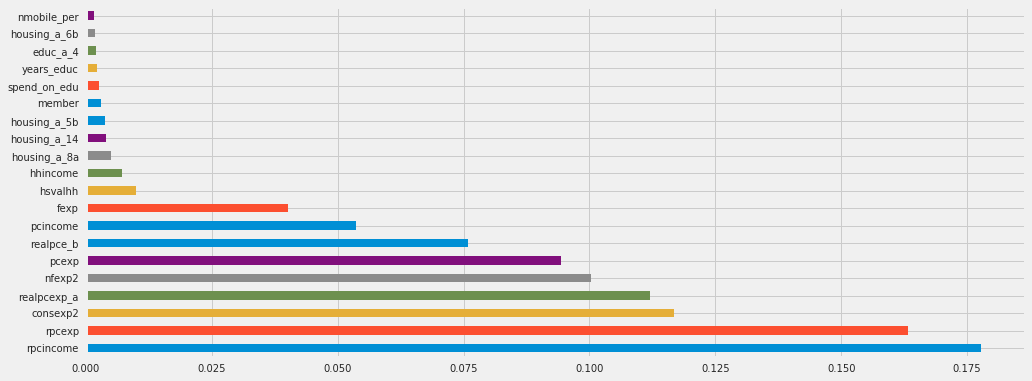

In [ ]:
X = df1.iloc[:,0:60]  #independent columns
y = df1.iloc[:,62:63]    #target column 
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

#Redundant & Correlated Household Variables 
The general guidelines for correlation values are below:

.00-.19 “very weak”      
.20-.39 “weak”        
.40-.59 “moderate”      
.60-.79 “strong”        
.80-1.0 “very strong”     

In [ ]:
# Create correlation matrix
corr_matrix = df1.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['educ_a_3',
 'years_educ',
 'nwrite_per',
 'realpce_b',
 'pcexp',
 'rpcexp',
 'rpcincome',
 'upperpoor']

In [ ]:
print(corr_matrix.loc[corr_matrix['educ_a_3'].abs() > 0.9, corr_matrix['educ_a_3'].abs() > 0.9])
print("\n",corr_matrix.loc[corr_matrix['years_educ'].abs() > 0.9, corr_matrix['years_educ'].abs() > 0.9])
print("\n",corr_matrix.loc[corr_matrix['realpce_b'].abs() > 0.9, corr_matrix['realpce_b'].abs() > 0.9])
print("\n",corr_matrix.loc[corr_matrix['pcexp'].abs() > 0.9, corr_matrix['pcexp'].abs() > 0.9])
print("\n",corr_matrix.loc[corr_matrix['rpcincome'].abs() > 0.9, corr_matrix['rpcincome'].abs() > 0.9])

          educ_a_2  educ_a_3  educ_a_4
educ_a_2  1.000000  0.958431  0.924996
educ_a_3  0.958431  1.000000  0.900242
educ_a_4  0.924996  0.900242  1.000000

             educ_a_5  years_educ
educ_a_5     1.00000     0.97717
years_educ   0.97717     1.00000

              realpcexp_a  realpce_b     pcexp    rpcexp
realpcexp_a     1.000000   0.999763  0.985429  1.000000
realpce_b       0.999763   1.000000  0.985079  0.999763
pcexp           0.985429   0.985079  1.000000  0.985429
rpcexp          1.000000   0.999763  0.985429  1.000000

              realpcexp_a  realpce_b     pcexp    rpcexp
realpcexp_a     1.000000   0.999763  0.985429  1.000000
realpce_b       0.999763   1.000000  0.985079  0.999763
pcexp           0.985429   0.985079  1.000000  0.985429
rpcexp          1.000000   0.999763  0.985429  1.000000

            hhincome  pcincome  rpcincome
hhincome   1.000000  0.916038   0.915019
pcincome   0.916038  1.000000   0.995483
rpcincome  0.915019  0.995483   1.000000


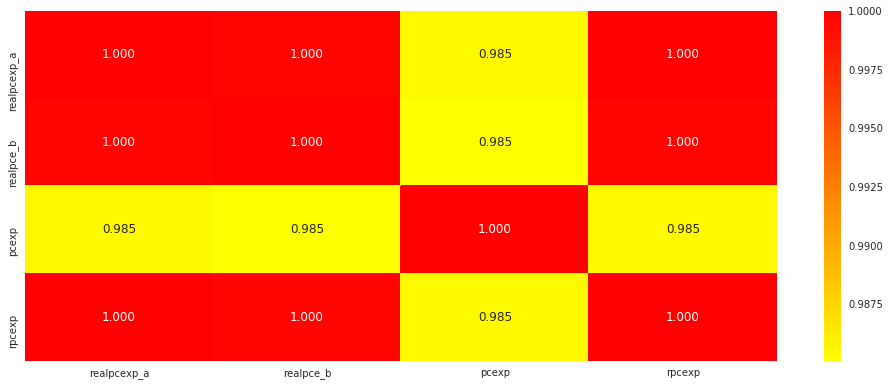

In [ ]:
sns.heatmap(corr_matrix.loc[corr_matrix['pcexp'].abs() > 0.9, corr_matrix['pcexp'].abs() > 0.9],
            annot=True, cmap = plt.cm.autumn_r, fmt='.3f');

In [ ]:
#most positive and negative correlated values
df1 = df1.loc[df1['lowerpoor'].notnull(), :].copy()

pcorrs = pd.DataFrame(df1.corr()['lowerpoor'].sort_values()).rename(columns = {'lowerpoor': 'pcorr'}).reset_index()
pcorrs = pcorrs.rename(columns = {'index': 'feature'})

print('Most negatively correlated variables:')
print(pcorrs.head())

print('\nMost positively correlated variables:')
print(pcorrs.dropna().tail(10))



Most negatively correlated variables:
       feature     pcorr
0        pcexp -0.251739
1  realpcexp_a -0.250303
2       rpcexp -0.250303
3    realpce_b -0.250004
4         fexp -0.229942

Most positively correlated variables:
              feature     pcorr
54           educ_a_4  0.138247
55           educ_a_3  0.140021
56           educ_a_2  0.140238
57             member  0.161202
58       housing_a_14  0.215980
59       housing_a_8a  0.226123
60  upperpoorquarters  0.666182
61          upperpoor  0.669656
62  lowerpoorquarters  0.940650
63          lowerpoor  1.000000


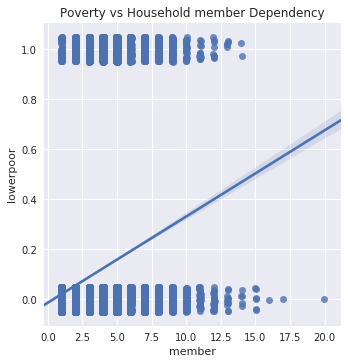

In [ ]:
sns.lmplot('member', 'lowerpoor', fit_reg = True, data = df1, x_jitter=0.05, y_jitter=0.05);
plt.title('Poverty vs Household member Dependency');

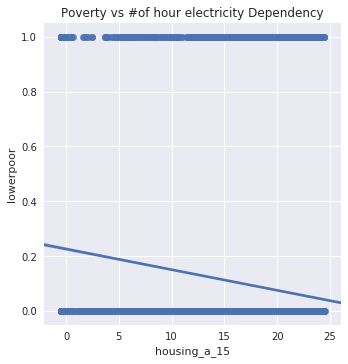

In [ ]:
sns.lmplot('housing_a_15', 'lowerpoor', fit_reg = True, data = df1, x_jitter=0.5, y_jitter=0.0005);
plt.title('Poverty vs #of hour electricity Dependency');


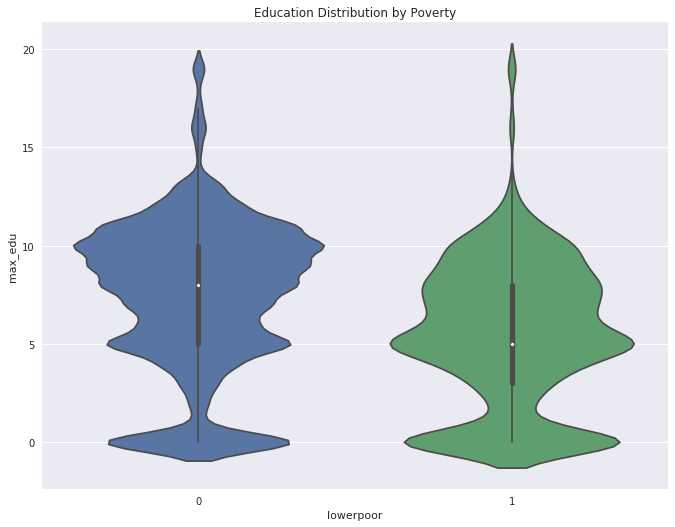

In [ ]:
plt.figure(figsize = (10, 8))
sns.violinplot(x = 'lowerpoor', y = 'max_edu', data = df1);
plt.title('Education Distribution by Poverty');

# Correlation Heatmap

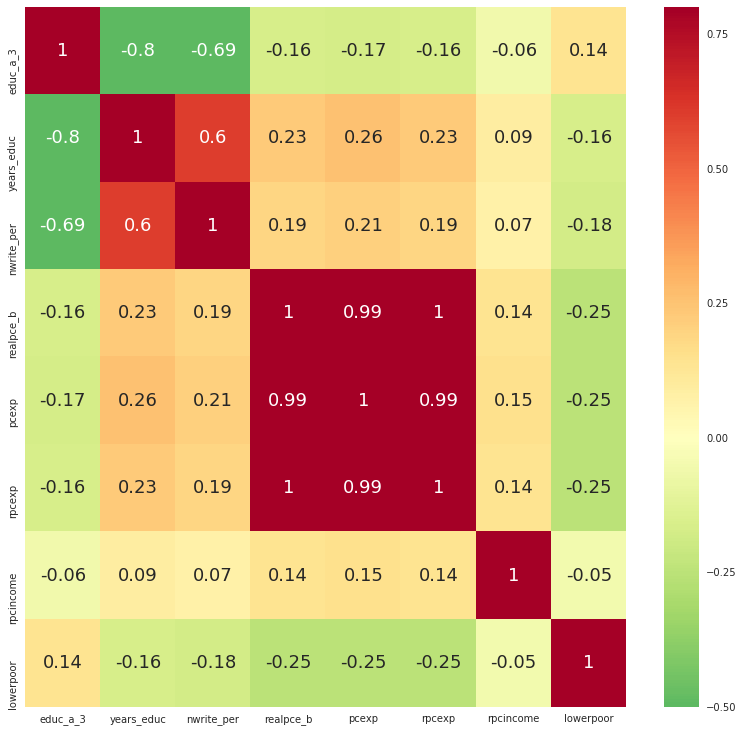

In [ ]:
variables = ['educ_a_3',
 'years_educ',
 'nwrite_per',
 'realpce_b',
 'pcexp',
 'rpcexp',
 'rpcincome',
 'lowerpoor']

# Calculate the correlations
corr_mat = df1[variables].corr().round(2)

# Draw a correlation heatmap
plt.rcParams['font.size'] = 18
plt.figure(figsize = (12, 12))
sns.heatmap(corr_mat, vmin = -0.5, vmax = 0.8, center = 0, 
            cmap = plt.cm.RdYlGn_r, annot = True);

# Feature Selection
As a first round of feature selection, we can remove one out of every pair of variables with a correlation greater than 0.95.

In [ ]:
# Create correlation matrix
corr_matrix = df1.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print(f'There are {len(to_drop)} correlated columns to remove.')
print(to_drop)

There are 8 correlated columns to remove.
['educ_a_3', 'years_educ', 'nwrite_per', 'realpce_b', 'pcexp', 'rpcexp', 'rpcincome', 'upperpoor']


In [ ]:
df2_noCorr = df1.drop(columns = to_drop)

In [ ]:
#chi_square method
from scipy.stats import chisquare
from scipy import stats

In [ ]:
df2_noCorr.columns

Index(['roster_a_5', 'roster_a_6b', 'roster_a_7', 'roster_a_13', 'educ_a_2',
       'educ_a_4', 'educ_a_5', 'health_a1_1', 'member', 'nmobile_per',
       'nemployed_per', 'nread_per', 'max_edu', 'avg_edu_yr', 'spend_on_edu',
       'tot_sci', 'spend_on_health', 'housing_a_2', 'housing_a_3',
       'housing_a_4a', 'housing_a_4c', 'housing_a_5b', 'housing_a_6b',
       'housing_a_7', 'housing_a_8a', 'housing_a_8b', 'housing_a_9',
       'housing_a_13', 'housing_a_14', 'housing_a_15', 'housing_a_17',
       'housing_a_18', 'housing_a_19', 'housing_a_21b', 'housing_a_22',
       'housing_a_25', 'agri_a_6', 'tot_income', 'tot_agri_val', 'urbrural_a',
       'zf_a', 'realpcexp_a', 'quarter', 'ruc', 'division_code',
       'zu16quarters', 'zl16quarters', 'fexp', 'hsvalhh', 'nfexp2', 'consexp2',
       'hhincome', 'pcincome', 'lowerpoorquarters', 'upperpoorquarters',
       'lowerpoor'],
      dtype='object')

# Train Test Split

In [ ]:
df2_noCorr.columns

Index(['roster_a_5', 'roster_a_6b', 'roster_a_7', 'roster_a_13', 'educ_a_2',
       'educ_a_4', 'educ_a_5', 'health_a1_1', 'member', 'nmobile_per',
       'nemployed_per', 'nread_per', 'max_edu', 'avg_edu_yr', 'spend_on_edu',
       'tot_sci', 'spend_on_health', 'housing_a_2', 'housing_a_3',
       'housing_a_4a', 'housing_a_4c', 'housing_a_5b', 'housing_a_6b',
       'housing_a_7', 'housing_a_8a', 'housing_a_8b', 'housing_a_9',
       'housing_a_13', 'housing_a_14', 'housing_a_15', 'housing_a_17',
       'housing_a_18', 'housing_a_19', 'housing_a_21b', 'housing_a_22',
       'housing_a_25', 'agri_a_6', 'tot_income', 'tot_agri_val', 'urbrural_a',
       'zf_a', 'realpcexp_a', 'quarter', 'ruc', 'division_code',
       'zu16quarters', 'zl16quarters', 'fexp', 'hsvalhh', 'nfexp2', 'consexp2',
       'hhincome', 'pcincome', 'lowerpoorquarters', 'upperpoorquarters',
       'lowerpoor'],
      dtype='object')

In [ ]:
X = df2_noCorr_Normalize.iloc[:,0:53] 
features = X.columns

In [ ]:
y = df2_noCorr.iloc[:,55:56]
target = y.columns

In [ ]:
train, test = train_test_split(df2_noCorr, test_size = 0.3)
print(len(df2_noCorr))
print(len(train))
print(len(test))

45812
32068
13744


In [ ]:
x_train = train[features]
y_train = train[target]

x_test = test[features]
y_test = test[target]

In [ ]:
#normalization
x_train = (x_train-x_train.mean())/(x_train.max()-x_train.min())
x_test = (x_test-x_test.mean())/(x_test.max()-x_test.min())

In [ ]:
x_train.head()

,roster_a_5,roster_a_6b,roster_a_7,roster_a_13,educ_a_2,educ_a_4,educ_a_5,health_a1_1,member,nmobile_per,nemployed_per,nread_per,max_edu,avg_edu_yr,spend_on_edu,tot_sci,spend_on_health,housing_a_2,housing_a_3,housing_a_4a,housing_a_4c,housing_a_5b,housing_a_6b,housing_a_7,housing_a_8a,housing_a_8b,housing_a_9,housing_a_13,housing_a_14,housing_a_15,housing_a_17,housing_a_18,housing_a_19,housing_a_21b,housing_a_22,housing_a_25,agri_a_6,tot_income,tot_agri_val,urbrural_a,zf_a,realpcexp_a,quarter,ruc,division_code,zu16quarters,zl16quarters,fexp,hsvalhh,nfexp2,consexp2,hhincome,pcincome
191,-0.042379,-0.036097,-0.081015,-0.10749,0.280201,0.292472,-0.207396,0.153642,-0.107645,0.060643,0.177535,-0.585171,-0.379414,-0.176124,-0.001071,0.029829,-0.000624,0.032662,0.068121,-0.102236,0.017592,-0.045674,-0.038456,-0.007019,0.161095,0.123378,-0.003165,0.122594,0.364226,-0.551662,0.005036,0.014298,0.036656,-0.082845,-0.002981,0.019069,0.000729,-0.007405,0.415523,-0.303293,-0.098042,0.041555,0.168964,-0.174239,-0.52781,-0.124603,-0.035963,0.034978,-0.005431,-0.004054,0.007108,-0.000745,0.001940
17601,-0.042379,0.059793,-0.081015,0.39251,0.280201,0.292472,-0.207396,-0.346358,0.050250,0.160643,-0.122465,0.214829,0.041638,-0.058477,0.007885,0.029829,-0.000624,-0.005800,0.068121,-0.102236,-0.125265,-0.045674,-0.038456,-0.004473,0.161095,-0.376622,-0.003165,-0.044073,-0.135774,0.365004,0.005036,0.014298,0.036656,-0.082845,-0.004169,0.019069,0.000149,-0.006072,0.082190,-0.303293,-0.041220,0.008189,0.502297,-0.174239,-0.12781,-0.042618,0.055555,0.005141,0.004688,0.011332,0.012903,0.000173,-0.000744
9093,-0.042379,-0.090892,0.418985,-0.10749,-0.219799,-0.207528,0.318919,0.153642,-0.002381,0.060643,-0.322465,0.164829,0.146902,0.044464,0.001035,0.029829,-0.000624,0.032662,-0.431879,-0.102236,0.017592,0.287660,-0.038456,0.033345,-0.172238,0.123378,-0.003165,0.122594,-0.135774,0.198338,0.005036,0.014298,-0.463344,-0.082845,0.049519,0.019069,-0.001231,0.000595,-0.251143,-0.303293,0.275117,0.017200,0.502297,-0.174239,-0.32781,0.184797,0.340531,0.017564,0.007688,0.013046,0.018563,0.000105,-0.000059
24843,-0.042379,-0.063494,-0.081015,-0.10749,-0.219799,-0.207528,0.108393,0.153642,-0.055013,0.227310,0.010869,0.414829,-0.063625,0.059170,-0.000612,-0.081282,-0.000624,-0.025030,0.068121,-0.102236,0.017592,0.120993,0.161544,-0.003019,-0.338905,-0.376622,-0.003165,0.122594,-0.135774,0.073338,0.005036,0.014298,0.036656,-0.082845,-0.004231,0.019069,-0.001311,-0.009405,-0.251143,-0.303293,-0.457258,-0.005561,0.502297,-0.174239,0.07219,-0.177996,-0.238260,-0.012992,-0.001312,-0.004612,-0.008722,-0.001554,-0.001038
10343,-0.042379,0.032396,-0.081015,-0.10749,0.280201,0.292472,-0.207396,-0.346358,0.155513,-0.296500,-0.179607,-0.156599,-0.168888,-0.176124,-0.000626,0.029829,-0.000624,0.013431,0.068121,-0.102236,0.017592,-0.045674,-0.038456,0.002436,-0.005571,0.123378,-0.003165,0.122594,0.364226,-0.551662,0.005036,0.014298,0.036656,-0.082845,-0.005681,0.019069,-0.001131,-0.008605,-0.251143,-0.303293,0.275117,-0.012714,0.502297,-0.174239,-0.32781,0.184797,0.340531,0.000848,-0.002512,-0.003899,-0.003606,-0.002540,-0.003155


In [ ]:
#53 features

# Machine learning model

In [ ]:
# Model imports
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
#from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

In [ ]:
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [ ]:
# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [ ]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1)
# 10 fold cross validation
cv_score = cross_val_score(model, x_train, y_train, cv = 10, scoring = scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.9855 with std = 0.0039


# Feature Importance
feature importances don't tell us which direction of the feature is important (for example, we can't use these to tell whether more or less education leads to poverty) they only tell us which features the model considered relevant.

In [ ]:
y_train.head()

,lowerpoor
191,0
17601,0
9093,0
24843,0
10343,1


In [ ]:
model.fit(x_train, y_train)

# Feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances.head()

,feature,importance
0,roster_a_5,0.001135
1,roster_a_6b,0.004688
2,roster_a_7,0.001301
3,roster_a_13,0.001677
4,educ_a_2,0.000825


In [ ]:
def plot_feature_importances(df, n = 10, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()

    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

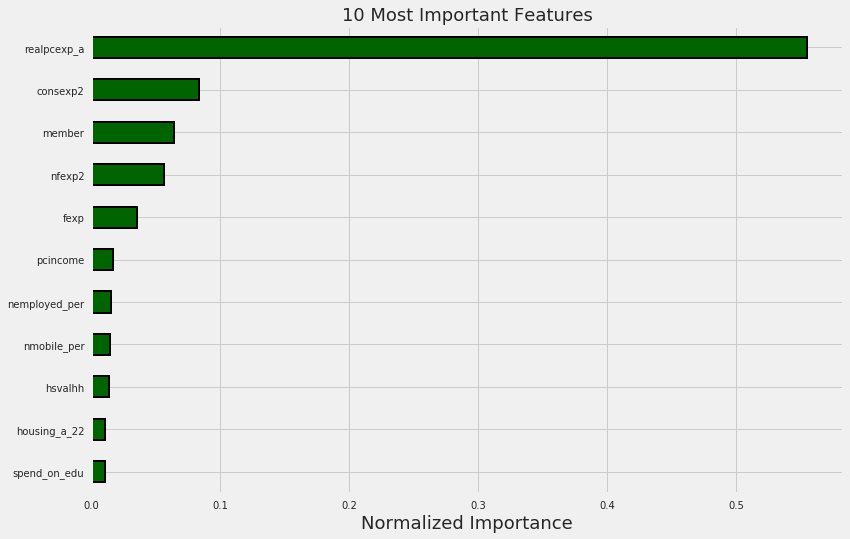

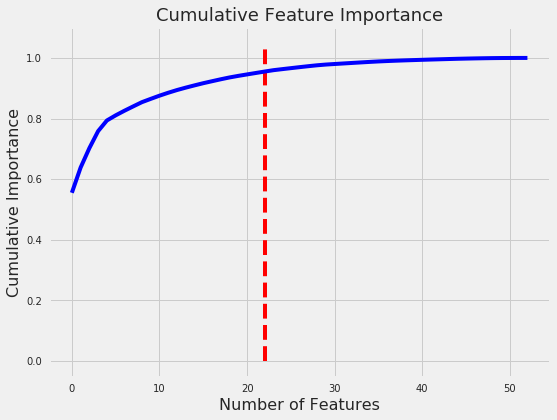

22 features required for 95% of cumulative importance.


In [ ]:
imp_feature = plot_feature_importances(feature_importances, threshold=0.95)

In [ ]:
def kde_target(df, variable):
    """Plots the distribution of `variable` in `df` colored by the `Target` column"""
    
    colors = {0: 'green', 1: 'red'}

    plt.figure(figsize = (12, 8))
    
    df = df2_noCorr[df2_noCorr['lowerpoor'].notnull()]
    
    for level in df2_noCorr['lowerpoor'].unique():
        subset = df2_noCorr[df2_noCorr['lowerpoor'] == level].copy()
        sns.kdeplot(subset[variable].dropna(), 
                    label = f'Poverty Level: {level}', 
                    color = colors[int(subset['lowerpoor'].unique())])

    plt.xlabel(variable); plt.ylabel('Density');
    plt.title('{} Distribution'.format(variable.capitalize()));

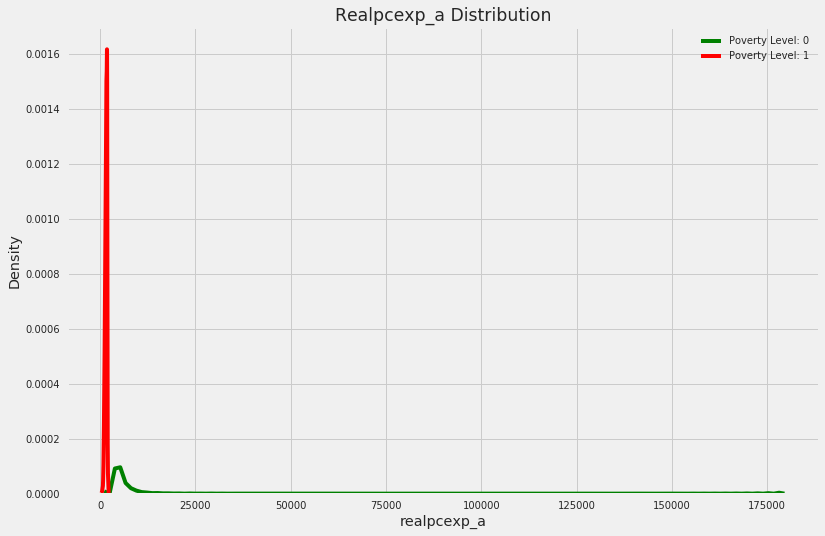

In [ ]:
kde_target(df2_noCorr, 'realpcexp_a')

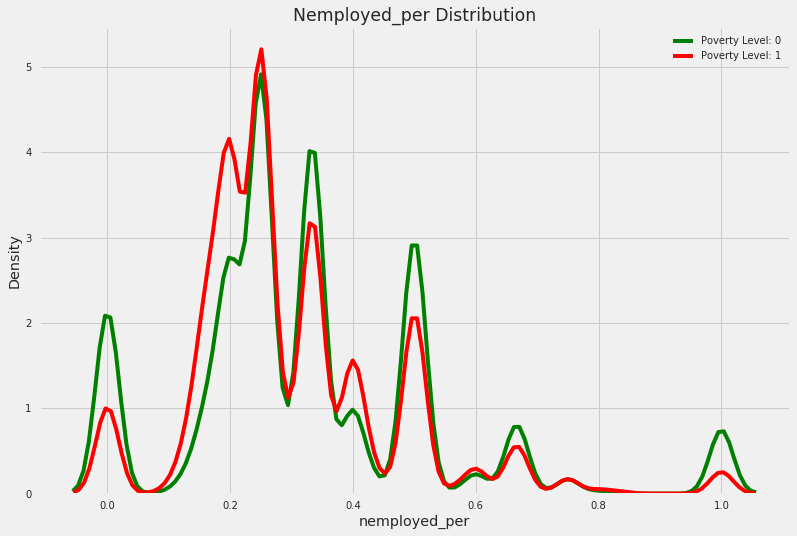

In [ ]:
kde_target(df2_noCorr, 'nemployed_per')

In [ ]:
#PCA Analysis

Text(0,0.5,'explained_variance_ratio_')

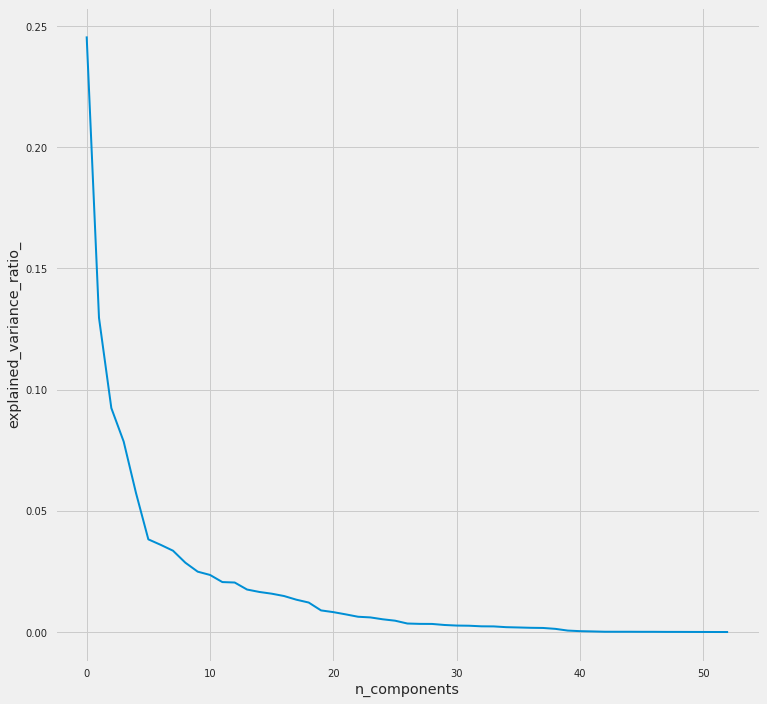

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train)

plt.figure(1, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [ ]:
#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Feature ranking:
1. feature 41 (0.593364)
2. feature 50 (0.102570)
3. feature 8 (0.040542)
4. feature 47 (0.034881)
5. feature 49 (0.023649)
6. feature 10 (0.020283)
7. feature 29 (0.014587)
8. feature 9 (0.012241)
9. feature 48 (0.012085)
10. feature 14 (0.011695)
11. feature 52 (0.011115)
12. feature 51 (0.009106)
13. feature 13 (0.008823)
14. feature 45 (0.008568)
15. feature 40 (0.007913)
16. feature 11 (0.007082)
17. feature 12 (0.006424)
18. feature 28 (0.005613)
19. feature 34 (0.005591)
20. feature 2 (0.005470)
21. feature 24 (0.005065)
22. feature 46 (0.004790)
23. feature 21 (0.004632)
24. feature 44 (0.004553)
25. feature 43 (0.004122)
26. feature 36 (0.003943)
27. feature 23 (0.003855)
28. feature 6 (0.003698)
29. feature 1 (0.003270)
30. feature 39 (0.002290)
31. feature 17 (0.001870)
32. feature 15 (0.001846)
33. feature 42 (0.001446)
34. feature 27 (0.001427)
35. feature 38 (0.001396)
36. feature 37 (0.001358)
37. feature 0 (0.001104)
38. feature 7 (0.000880)
39. feature

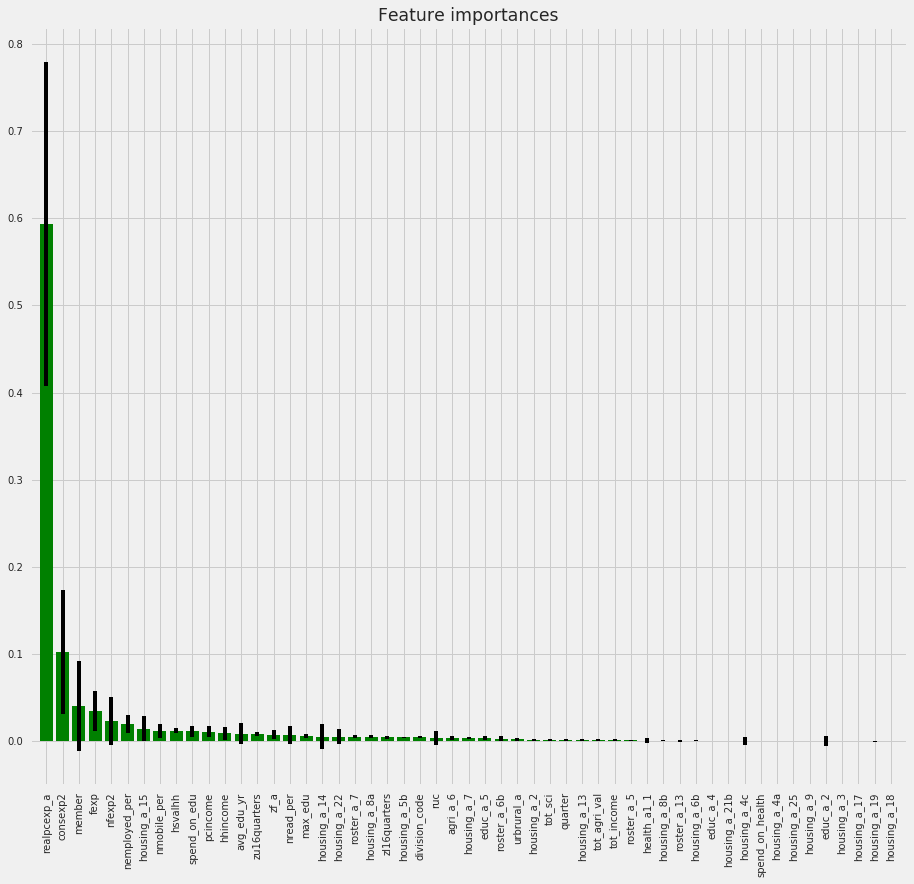

In [ ]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(x_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clr_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

# Model Selection

In [ ]:
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

In [ ]:

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=scorer, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                            'cv_std': cv_scores.std()},
                                                           index = [0]),
                                             ignore_index = True)

        return model_results

In [ ]:
model_results = cv_model(x_train, y_train, 
                         GaussianNB(), 'GNB', model_results)

10 Fold CV Score: 0.67048 with std: 0.00931


In [ ]:
model_results = cv_model(x_train, y_train,
                          RandomForestClassifier(),
                              'RF', model_results)

10 Fold CV Score: 0.97948 with std: 0.00454


In [ ]:
model_results = cv_model(x_train, y_train, 
                          LinearDiscriminantAnalysis(), 
                          'LDA', model_results)

10 Fold CV Score: 0.65624 with std: 0.01035


# Comparing Model Performance

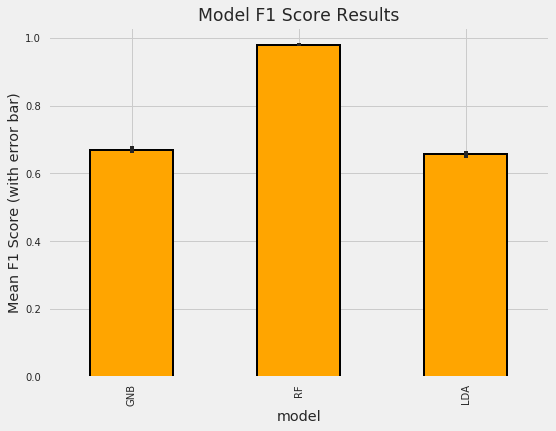

In [ ]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

# Decision Tree

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classife
clf = clf.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)

In [ ]:
# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9422293364377182


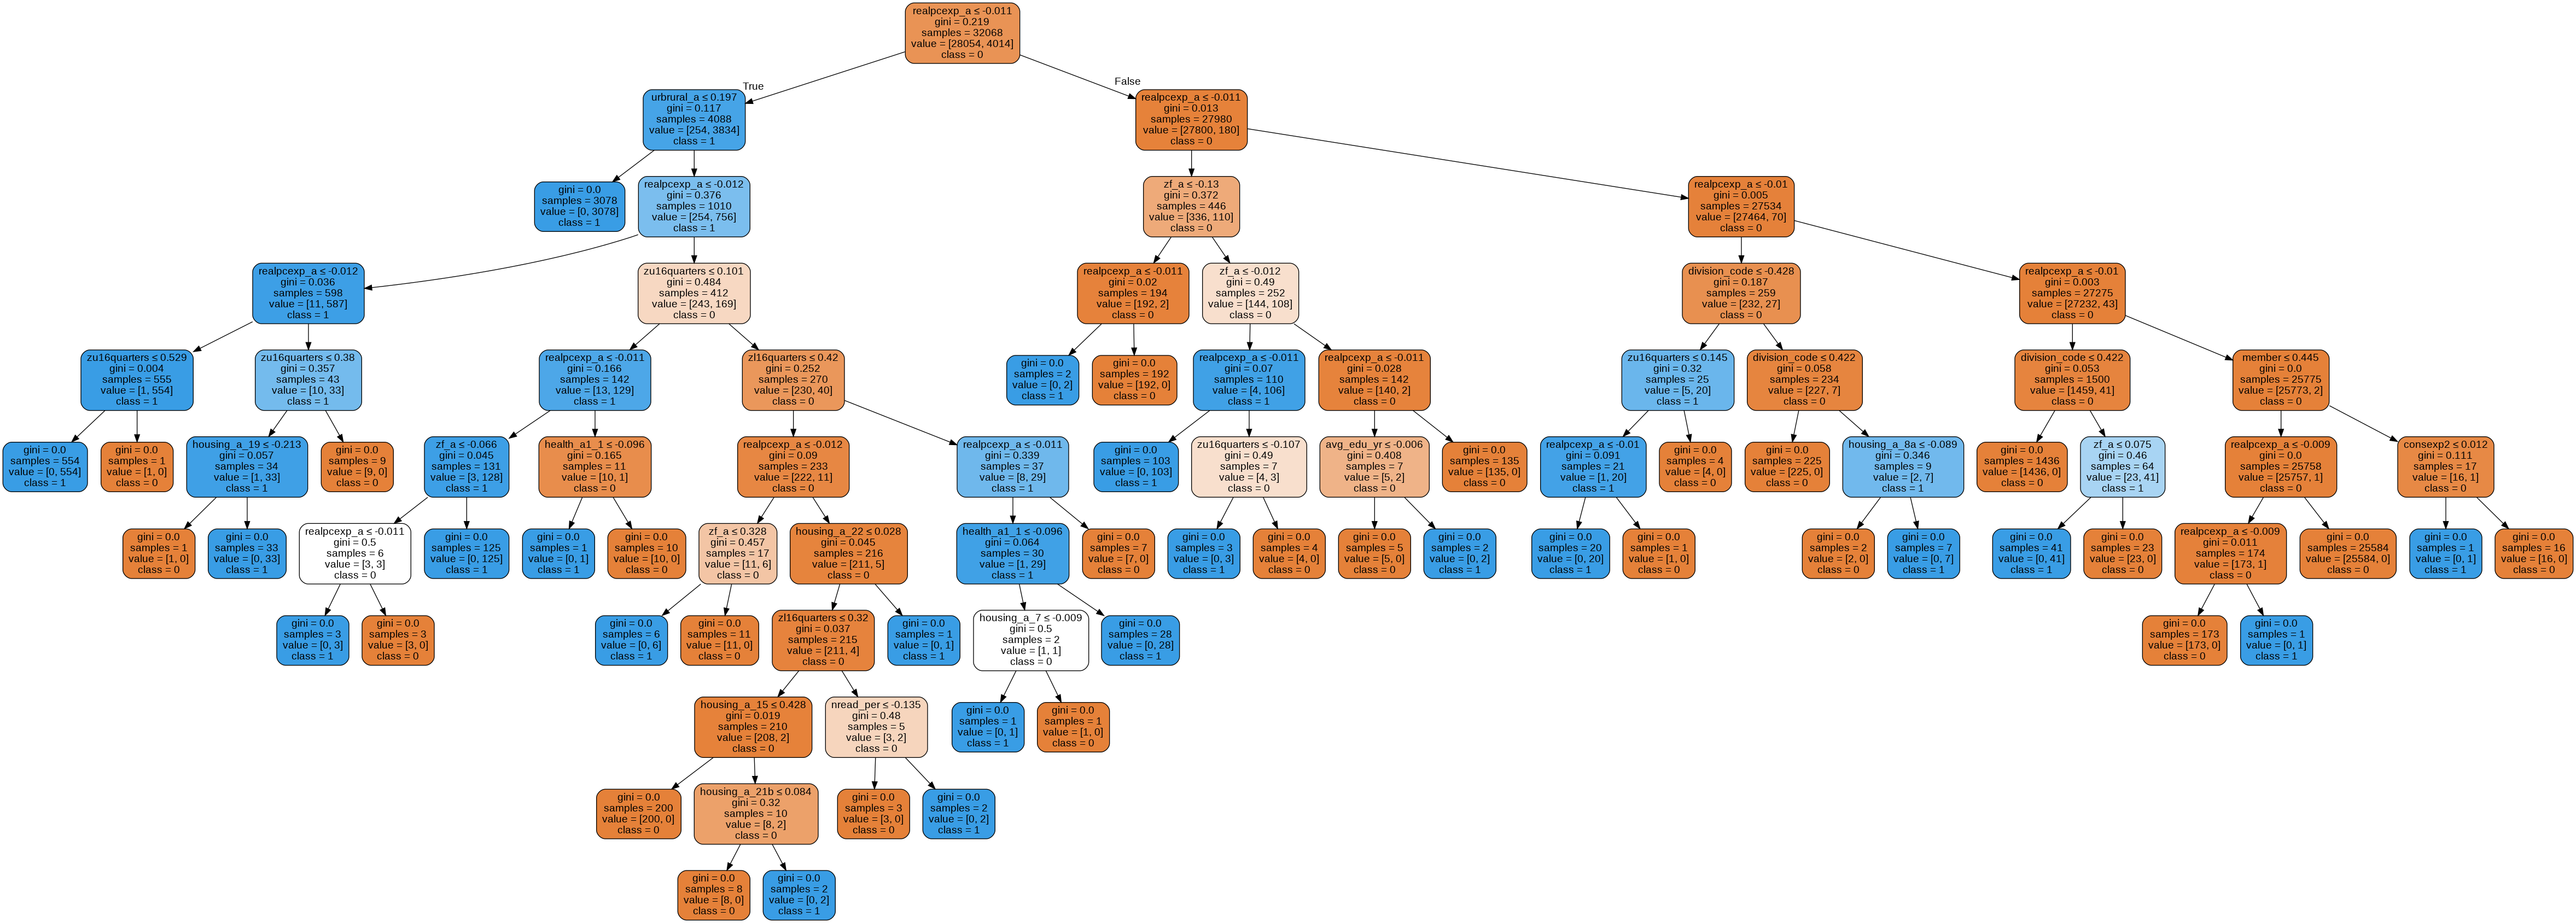

In [ ]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Poverty.png')
Image(graph.create_png())

# Optimized Decision Tree

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9482683352735739


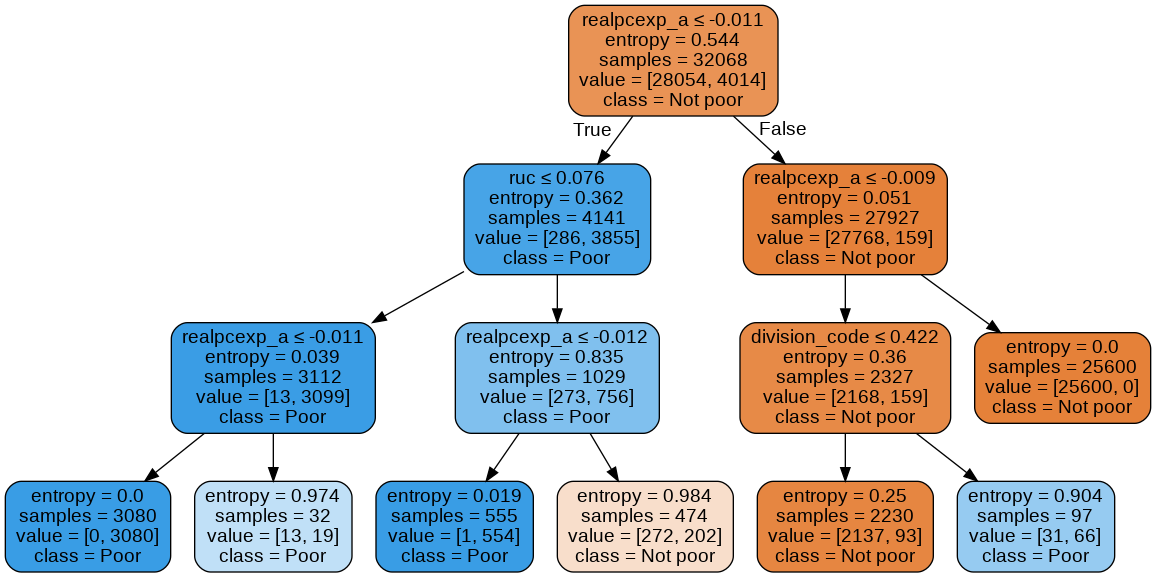

In [ ]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = features,class_names=['Not poor','Poor'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('poverty.png')
Image(graph.create_png())

# LightGBM
LightGBM, short for Light Gradient Boosted Machine, is a free and open source distributed gradient boosting framework for machine learning originally developed by Microsoft.  It is designed to be distributed and efficient with the following advantages: Faster training speed and higher efficiency. Lower memory usage.

In [ ]:
import lightgbm as lgb
classifier = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.1, objective='binary',
                             random_state=None, silent=True, metric='None', 
                             n_jobs=2, n_estimators=5000, class_weight='balanced',
                             colsample_bytree =  0.93, min_child_samples = 95, num_leaves = 14, subsample = 0.96)

In [ ]:
eval_set = [(x_train, y_train), (x_test, y_test)]
classifier.fit(x_train, y_train, eval_metric="binary", eval_set=eval_set, verbose=True, early_stopping_rounds=400) #LGBoost model model
y_pred = classifier.predict(x_test) 
y_pred = y_pred.reshape(-1, 1)

[1]	training's binary_logloss: 0.601314	valid_1's binary_logloss: 0.612439
Training until validation scores don't improve for 400 rounds.
[2]	training's binary_logloss: 0.525804	valid_1's binary_logloss: 0.547292
[3]	training's binary_logloss: 0.462631	valid_1's binary_logloss: 0.493353
[4]	training's binary_logloss: 0.409471	valid_1's binary_logloss: 0.449021
[5]	training's binary_logloss: 0.36394	valid_1's binary_logloss: 0.412131
[6]	training's binary_logloss: 0.329838	valid_1's binary_logloss: 0.405154
[7]	training's binary_logloss: 0.294626	valid_1's binary_logloss: 0.375705
[8]	training's binary_logloss: 0.263358	valid_1's binary_logloss: 0.349952
[9]	training's binary_logloss: 0.236512	valid_1's binary_logloss: 0.328836
[10]	training's binary_logloss: 0.212498	valid_1's binary_logloss: 0.310377
[11]	training's binary_logloss: 0.191862	valid_1's binary_logloss: 0.295311
[12]	training's binary_logloss: 0.172602	valid_1's binary_logloss: 0.281659
[13]	training's binary_logloss: 0.1

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test, y_pred)
print (cm1)

[[11084   898]
 [    0  1762]]


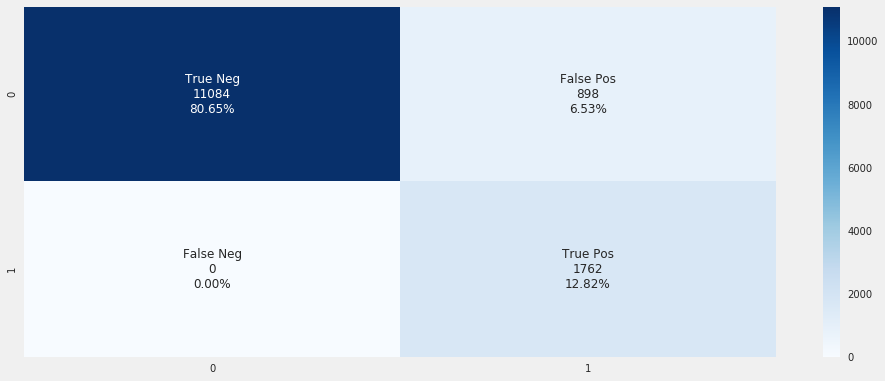

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm1.flatten()/np.sum(cm1)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm1, annot=labels, fmt='', cmap='Blues')

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average ='macro')
print ('f1 score for LGBoost model:',f1)

f1 score for LGBoost model: 0.8789963537663519


Text(0.5,1,'Feature importance')

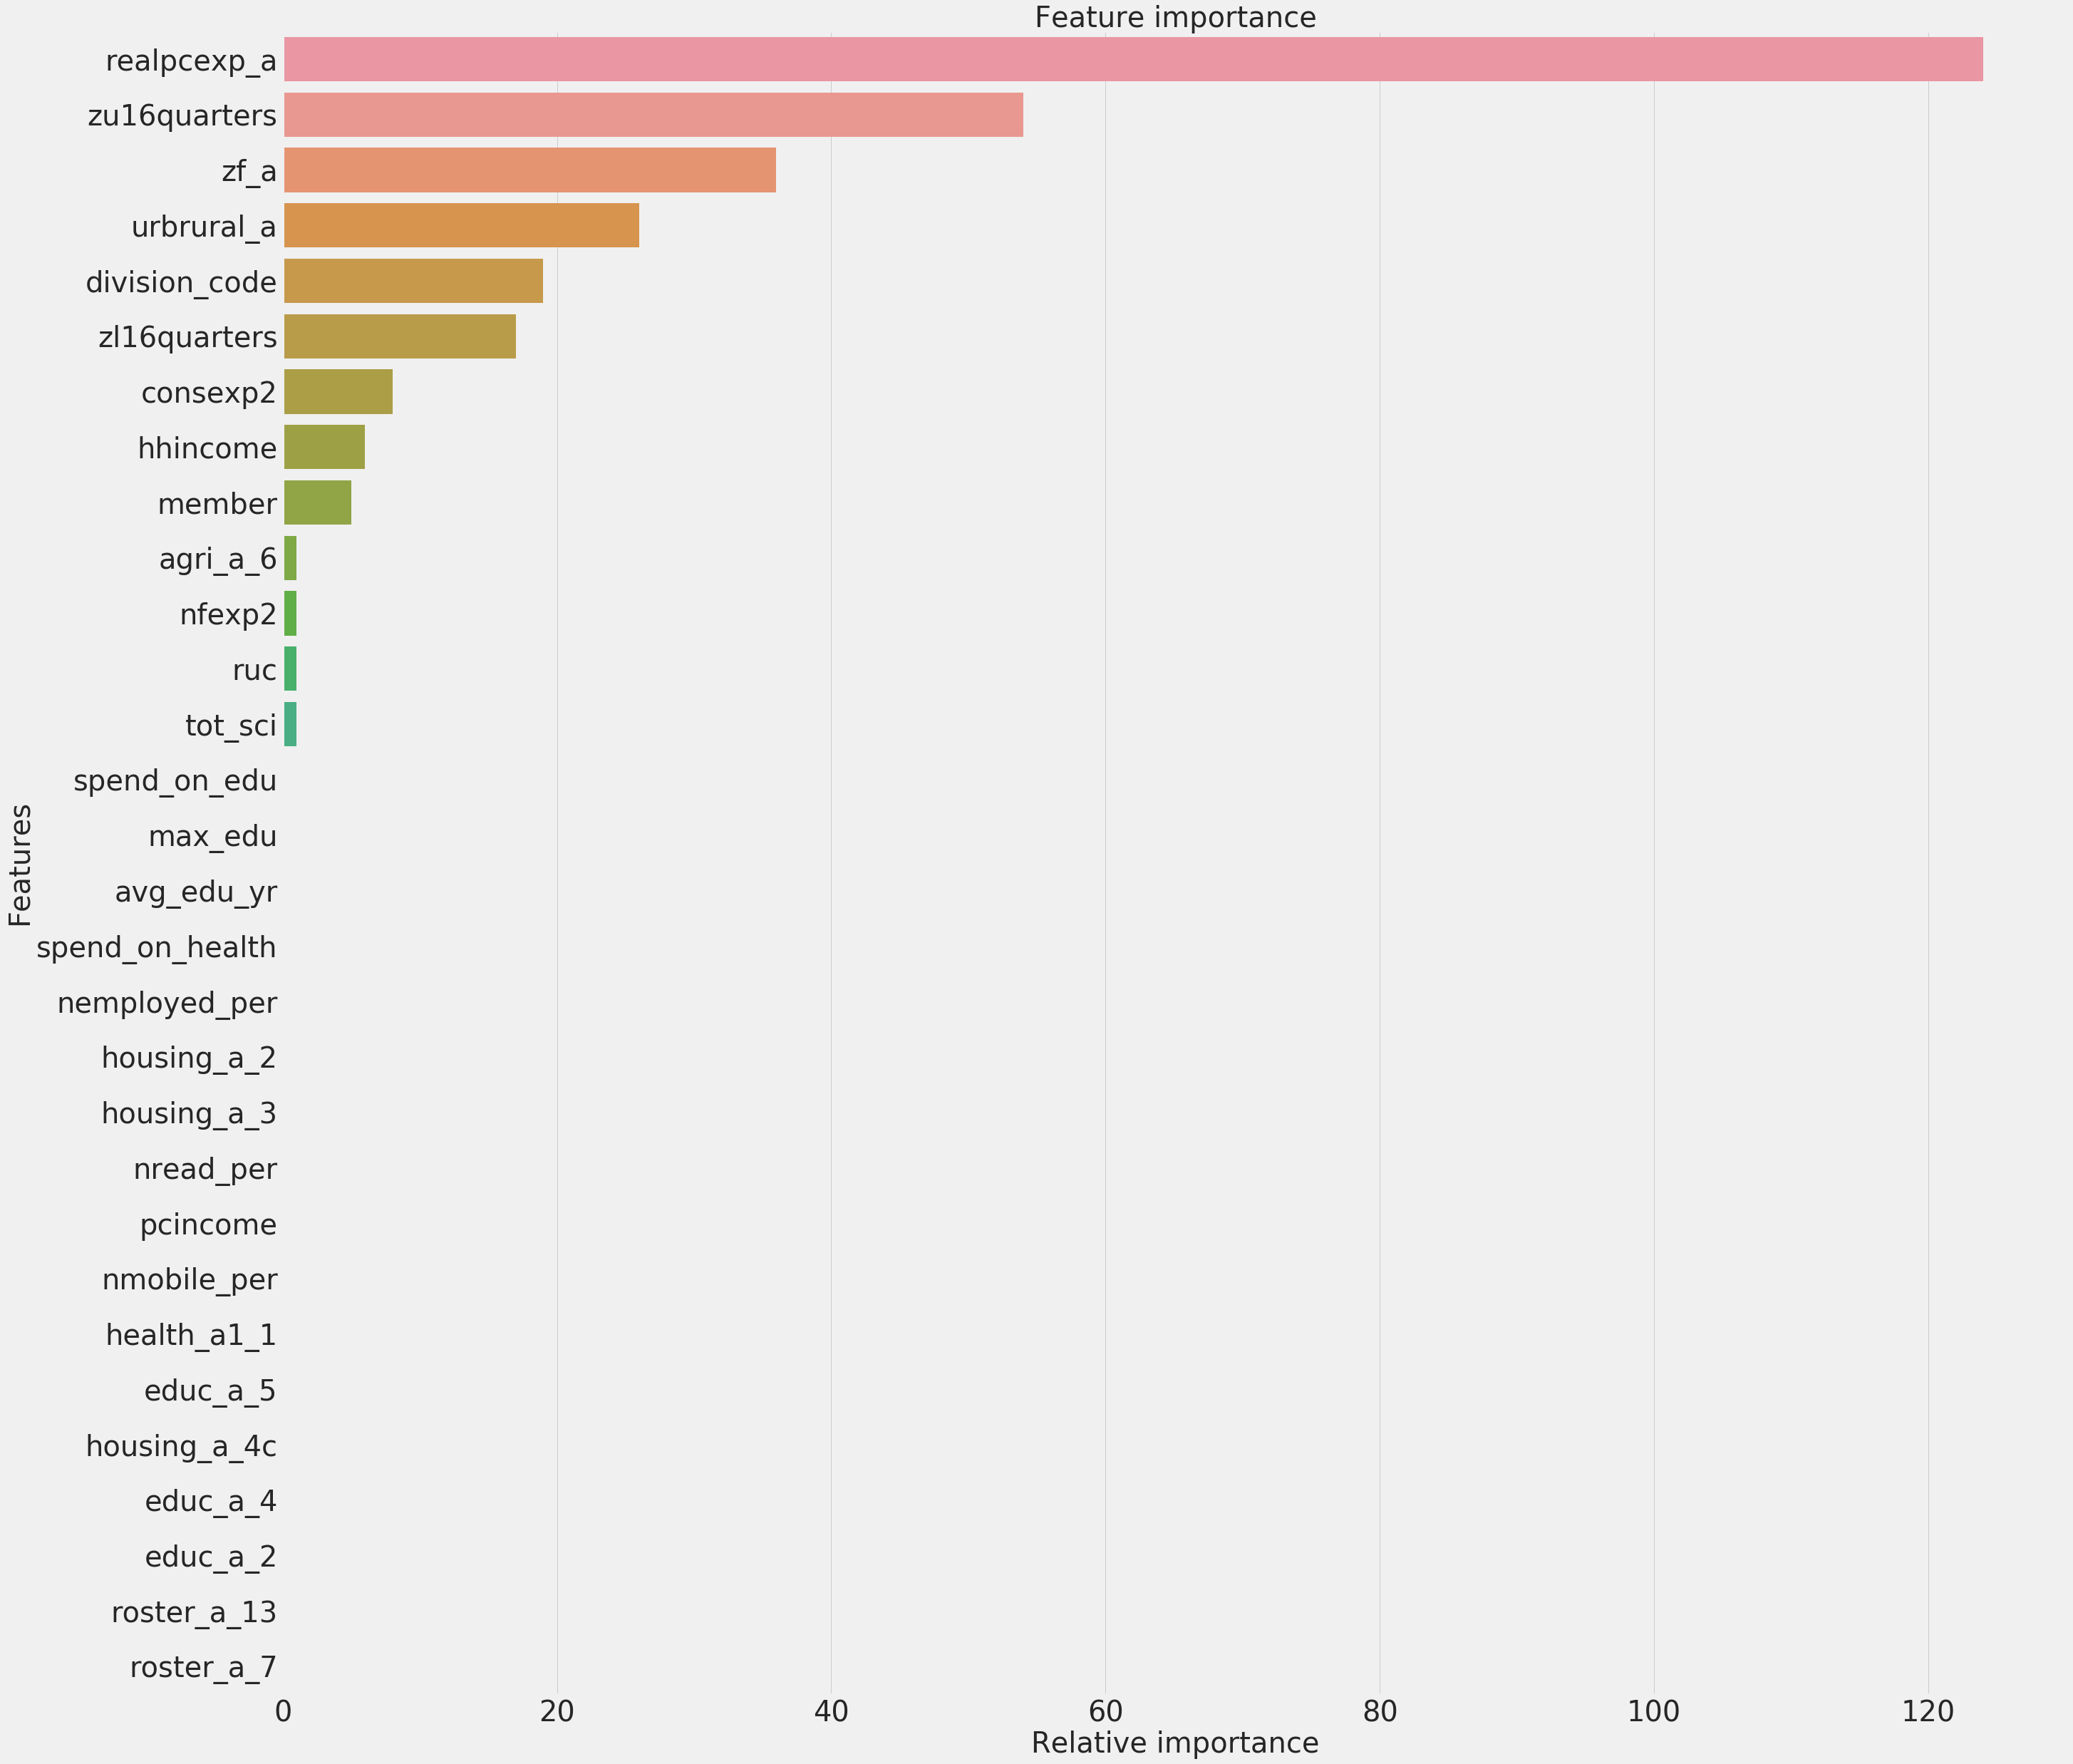

In [ ]:
# Visualise with a barplot
import seaborn as sns
indices = np.argsort(classifier.feature_importances_)[::-1]
indices = indices[:30]


plt.subplots(figsize=(40, 40))
g = sns.barplot(y=train.columns[indices], x = classifier.feature_importances_[indices], orient='h')
g.set_xlabel("Relative importance",fontsize=40)
g.set_ylabel("Features",fontsize=40)
g.tick_params(labelsize=40)
g.set_title("Feature importance", fontsize=40)